In [1]:
#!/usr/bin/env python

# core-exampe-comparison.ipynb

In [2]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# from mpl_toolkits import basemap
# import ESMF
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
# import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys 
import matplotlib.gridspec as gridspec
import seaborn
# from mpl_toolkits.basemap import Basemap, cm

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [3]:
from draft_functions import core_2d_properties, core_3d_properties, watersheding

In [4]:
# DX = ['500M','250M','125M']
# DT = [2,1,0.5]
# dx_m = [500,250,125] 

DX = ['250M']
DT = [1]
dx_m = [250] 
SIM_All = ['mao_20140401_15:00:00_',
        'mao_20140917_17:00:00_',
        'mao_20141004_13:00:00_',
        'mao_20141018_14:00:00_',
        'mao_20141117_18:00:00_',
        'mao_20141210_14:00:00_',
        'mao_20150328_15:00:00_',
        'mao_20150412_12:00:00_',
        'mao_20150621_14:00:00_',
        'mao_20151106_12:00:00_',
        'sgp_20120531_04:00:00_',
        'sgp_20120615_07:00:00_',
        'sgp_20130509_07:00:00_',
        'sgp_20130605_09:00:00_',
        'sgp_20130617_07:00:00_',
        'sgp_20140602_04:00:00_',
        'sgp_20140605_12:00:00_',
        'sgp_20140612_06:00:00_',
        'sgp_20140628_16:00:00_',
        'sgp_20140710_10:00:00_']
si = 10
SIM = SIM_All[si]
Site = SIM[:3].upper()

vwp_dir = '/glade/campaign/mmm/c3we/mingge/WRF_DOE/virtual_profiler_NetCDF/'
wrfout_dir = '/glade/campaign/mmm/c3we/mingge/WRF_DOE/'

VARS = ['WW','QS','QR','QC','QG','QV','TK','P'] # virtual profiler variables

In [5]:
grDATA = {}
for dx in range(len(DX)):
    vwp_file = vwp_dir + SIM_All[si][:-1] + '/' + DX[dx] + '/'+ SIM_All[si]+ '_'+ DX[dx] +'_Loc01.nc'
    ncfile = Dataset(vwp_file)
    height = np.squeeze(ncfile.variables["Height"])
    time = np.squeeze(ncfile.variables['Time'])
    ncfile.close()
    
    # from datetime import timedelta
    from datetime import datetime, timedelta
    StartDay = datetime(int(SIM[4:8]), int(SIM[8:10]), int(SIM[10:12]), int(SIM[13:15])) - timedelta(hours=6)
    StopDay = StartDay  + timedelta(hours=12)
    rgdTimeMCS = pd.date_range(StartDay, end=StopDay, freq=str(DT[dx])+'s') #'500ms')
    rgdTimeMCS = rgdTimeMCS[:len(time)]

    DATA = np.zeros((len(time),len(height), 20, len(VARS))); DATA[:] = np.nan
    lat_vs = np.zeros((20)); lat_vs[:] = np.nan
    lon_vs = np.copy(lat_vs)

    for lo in tqdm(range(20)):  
        loc = str(lo+1).zfill(2)
        vwp_file = vwp_dir + SIM_All[si][:-1] + '/' + DX[dx] + '/'+ SIM_All[si]+ '_'+ DX[dx] +'_Loc' + loc + '.nc'
        ncfile = Dataset(vwp_file)
        
        lat_vs[lo] = ncfile.getncattr('profiler latitude')
        lon_vs[lo] = ncfile.getncattr('profiler longitude')
        for va in range(len(VARS)):
            # print('    '+VARS[va])
            DATA[:,:,lo,va] = np.squeeze(ncfile.variables[VARS[va]])
        grDATA[DX[dx]] = DATA

100%|██████████| 20/20 [00:31<00:00,  1.55s/it]


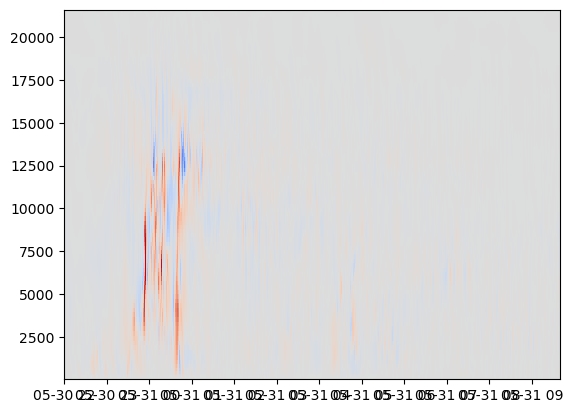

In [6]:
t0 = 0
t1 = 42000
loc = 8
plt.pcolormesh(rgdTimeMCS[t0:t1], height, DATA[t0:t1,:,loc,0].T, vmin=-25, vmax=25, cmap='coolwarm')

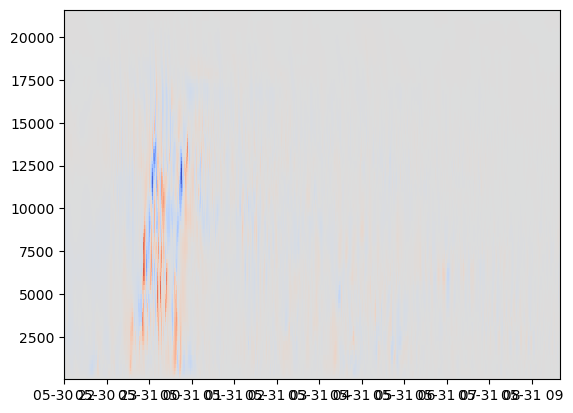

In [7]:
plt.pcolormesh(rgdTimeMCS[t0:t1], height, DATA[t0:t1,:,11,0].T, vmin=-25, vmax=25, cmap='coolwarm')

### Read in dBZ at 20th model leve

In [8]:
wrfout_files = np.sort(glob.glob(wrfout_dir+DX[dx]+'/Thomson_YSU/'+SIM+DX[dx]+'/wrfout_d02*'))
ncfile = Dataset(wrfout_files[0])
lat = np.squeeze(ncfile.variables["XLAT"])
lon = np.squeeze(ncfile.variables['XLONG'])
ncfile.close()

In [9]:
dbz = np.zeros((len(wrfout_files), lat.shape[0], lat.shape[1])); dbz[:] = np.nan
for tt in tqdm(range(len(wrfout_files))):
    ncfile = Dataset(wrfout_files[tt])
    dbz[tt,:,:] = np.squeeze(ncfile.variables["REFL_10CM"][0,20,:,:])
    ncfile.close()

100%|██████████| 72/72 [01:11<00:00,  1.01it/s]


In [10]:
# create time vector for wrfout files
import wrf
ncfile = Dataset(wrfout_files[0])
start_wrfout = wrf.extract_times(ncfile,0)
ncfile = Dataset(wrfout_files[-1])
stop_wrfout = wrf.extract_times(ncfile,0)

time_wrfout = pd.date_range(start_wrfout, end=stop_wrfout, freq='10min') #'500ms')

### Track high-reflectivity areas and determine their speed

In [11]:
idbz_threshold = 40
MinObjVolume = 4000000 # m2
iSmooth = 16000
rgiObj_Struct=np.zeros((3,3,3)); rgiObj_Struct[:,:,:]=1

iSmoothGC=int(iSmooth/dx_m[dx])
dbz_smooth=scipy.ndimage.uniform_filter(dbz[:,:,:],[1,iSmoothGC,iSmoothGC])

# threshold the dbz
rgiTH_dbz=(dbz_smooth >= idbz_threshold)
rgrdbz_thresholded=np.copy(dbz)
rgrdbz_thresholded[rgiTH_dbz == False]=0
rgiObjectsUD, nr_objectsUD = ndimage.label(rgiTH_dbz,structure=rgiObj_Struct)

# sort the objects according to their size
Objects=ndimage.find_objects(rgiObjectsUD)
rgiVolObj=np.array([np.sum(rgiObjectsUD[Objects[ob]] == ob+1) for ob in range(nr_objectsUD)])
rgiObBySize=np.array([np.where(np.sort(rgiVolObj)[::-1][ob] == rgiVolObj)[0][0] for ob in range(nr_objectsUD)])
rgiObBySize=rgiObBySize[rgiVolObj[rgiObBySize] >= MinObjVolume]

# create final object array
dbz_objects=np.copy(rgiObjectsUD); dbz_objects[:]=0
for ob in range(len(rgiObBySize)):
    dbz_objects[rgiObjectsUD == (rgiObBySize[ob]+1)] = ob+1
    


In [12]:
# print('        break up long living cores')
# from Tracking_Functions import BreakupObjects
# MS_objects, object_split = BreakupObjects(dbz_objects,
#                             3/6.,
#                             1/6.)



In [ ]:
dbz_objects = watersheding(dbz_objects[], 
                         int(4000/dx_m[dx]),
                         1)

In [ ]:
dbz_objects.shape

[(slice(1, 72, None), slice(1, 2999, None), slice(1, 2999, None)),
 (slice(1, 2, None), slice(6, 7, None), slice(2973, 2974, None)),
 (slice(1, 5, None), slice(10, 138, None), slice(545, 682, None)),
 (slice(1, 2, None), slice(11, 12, None), slice(2952, 2953, None)),
 (slice(1, 2, None), slice(14, 31, None), slice(2963, 2984, None)),
 (slice(1, 2, None), slice(23, 27, None), slice(2955, 2958, None)),
 (slice(1, 2, None), slice(41, 61, None), slice(2986, 2999, None)),
 (slice(1, 2, None), slice(65, 72, None), slice(790, 803, None)),
 (slice(1, 2, None), slice(74, 97, None), slice(2994, 2999, None)),
 (slice(1, 3, None), slice(81, 99, None), slice(763, 787, None)),
 (slice(1, 2, None), slice(90, 93, None), slice(638, 640, None)),
 (slice(1, 2, None), slice(132, 152, None), slice(778, 801, None)),
 (slice(1, 2, None), slice(146, 154, None), slice(759, 763, None)),
 (slice(1, 3, None), slice(150, 220, None), slice(498, 568, None)),
 (slice(1, 2, None), slice(154, 158, None), slice(416, 418

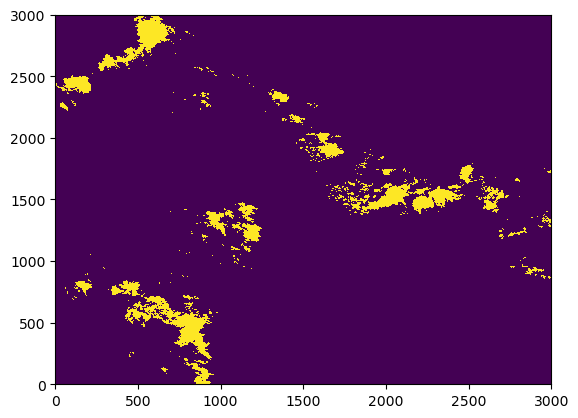

In [17]:
plt.pcolormesh(dbz_objects[4,:])

In [ ]:
from Tracking_Functions import calc_grid_distance_area
from Tracking_Functions import calc_object_characteristics
_,_,Area,Gridspacing = calc_grid_distance_area(lon,lat)

cell_obj_characteristics = calc_object_characteristics(MS_objects.astype('int'), # feature object file
                                     dbz,         # original file used for feature detection
                                     'tmp/cell_stats.pkl',
                                     rgdTimeMCS,            # timesteps of the data
                                     lat,             # 2D latidudes
                                     lon,             # 2D Longitudes
                                     Gridspacing,
                                     Area,
                                     min_tsteps=3,
                                     split_merge = 0)

In [ ]:
# get cores that intersect with virtual sounding locations

# get location of vs in grid
from Tracking_Functions import radialdistance
lat_vs_id = np.copy(lat_vs); lat_vs_id[:] = np.nan
lon_vs_id = np.copy(lat_vs_id)
for ii in tqdm(range(len(lat_vs))):
    mindist = radialdistance(lat,lon,lat_vs[ii],lon_vs[ii])
    min_loc = np.argwhere(mindist == np.min(mindist))[0]
    lat_vs_id[ii] = min_loc[0]
    lon_vs_id[ii] = min_loc[1]

lat_vs_id = lat_vs_id.astype('int')
lon_vs_id = lon_vs_id.astype('int')

In [ ]:
lat_vs

In [ ]:
dist = 60000 # m -- distance to extract arround the station
timewindow = 40 # minutes arround 2D obs
dx_dist = int(dist/dx_m[dx])

cores_vp_up = {}
cores_2d_up = {}
cores_3d_up = {}
cores_vp_down = {}
cores_2d_down = {}
cores_3d_down = {}

ud_min = 1.5
dd_min = 1.5
draft_th = [1.5,3.0,6.0,10.0]

direction = ['up', 'down']  # [ up - updraft; down - downdraft]

# loop over virtual profilers
for ii in tqdm(range(len(lat_vs))):
    conv_inters = np.unique(MS_objects[:,lat_vs_id[ii],lon_vs_id[ii]])[1:]
    la_start = lat_vs_id[ii] - dx_dist
    la_stop = lat_vs_id[ii] + dx_dist + 1
    lo_start = lon_vs_id[ii] - dx_dist
    lo_stop = lon_vs_id[ii] + dx_dist +1

    location = 'loc-'+str(ii).zfill(2)

    # virtual profiler data
    data_vp = grDATA[DX[dx]][:,:,ii,:]

    for ca in range(len(conv_inters)):
        conv_element = 'conv-'+str(ca).zfill(3)
        files_int = wrfout_files[conv_inters[ca] == (MS_objects[:,lat_vs_id[ii],lon_vs_id[ii]])]
        speed_ca_median = np.median(cell_obj_characteristics[str(conv_inters[ca])]['speed'])
        for fi in [0]: #range(len(files_int)):
            file_act = 'output-'+str(fi).zfill(2)
            ncfile = Dataset(files_int[fi])
            dbz_ca = np.squeeze(ncfile.variables["REFL_10CM"][0,:,la_start:la_stop,lo_start:lo_stop])
            w_ca = np.squeeze(ncfile.variables["W"][0,:,la_start:la_stop,lo_start:lo_stop])
            z_ca_stag = (np.squeeze(ncfile.variables["PHB"][0,:,la_start:la_stop,lo_start:lo_stop]) + \
                    np.squeeze(ncfile.variables["PH"][0,:,la_start:la_stop,lo_start:lo_stop])) / 9.81 - \
                    np.squeeze(ncfile.variables["HGT"][0,la_start:la_stop,lo_start:lo_stop])
            z_ca = (z_ca_stag[1:,:] + z_ca_stag[:-1,:])/2
            # brind 3D data to common grid
            dbz_ca_comz = wrf.interpz3d(dbz_ca, z_ca, height, missing = np.nan)
            w_ca_comz = wrf.interpz3d(w_ca, z_ca_stag, height, missing = np.nan)
            ncfile.close()

            # degrees to meters
            lon_m = np.linspace(0,Gridspacing*w_ca.shape[1], w_ca.shape[1]); lon_m = lon_m - np.mean(lon_m)
            lat_m = np.copy(lon_m)

            cloudmask = np.copy(dbz_ca_comz[:,dx_dist,:]); cloudmask[:] = 1
            cloudmask[0,:] = np.nan
            cloudmask[-1,:] = np.nan
            cloudmask[dbz_ca_comz[:,dx_dist,:] <= -30] = np.nan
            
            cloudmask_3d = np.copy(dbz_ca_comz[:,:,:]); cloudmask_3d[:] = 1
            cloudmask_3d[dbz_ca_comz[:,:,:] <= -30] = np.nan

#             plt.pcolormesh(lon_m/1000., height, w_ca_comz[:,dx_dist,:], vmin=-25, vmax=25, cmap='coolwarm')
#             plt.contour(lon_m/1000., height, w_ca_comz[:,dx_dist,:] > 5, colors = 'r')
#             plt.contour(lon_m/1000., height, w_ca_comz[:,dx_dist,:] < -5, colors = 'b')
#             plt.contour(lon_m/1000., height, 
#                            cloudmask > 0,
#                         colors='k')
#             plt.show()
            
#             stop()

            for di in range(len(direction)):
                if direction[di] == 'up':
                    dire_sign = 1
                elif direction[di] == 'down':
                    dire_sign = -1

                for th in range(len(draft_th)):
                    # WORKING ON 2D CORES
                    updrafts = w_ca_comz[:,dx_dist,:]  * dire_sign > draft_th[th]
                    rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts,structure=rgiObj_Struct[0,:,:])
                    # watershedding
                    rgiObjectsUD = watersheding(rgiObjectsUD, 
                         int(4000/dx_m[dx]),
                         1)
                    # sort the objects according to their size
                    Objects=ndimage.find_objects(rgiObjectsUD)
                                        
                    w_2D = np.copy(w_ca_comz[:,dx_dist,:]) * dire_sign
                    if direction[di] == 'up':
                        cores_2d_up[str(draft_th[th]).zfill(2)+'_'+location+'_'+conv_element+'_'+file_act] = core_2d_properties(Objects,
                                      w_2D,
                                      cloudmask,
                                      height,
                                      lon_m)
                    elif direction[di] == 'down':
                        cores_2d_down[str(draft_th[th]).zfill(2)+'_'+location+'_'+conv_element+'_'+file_act] = core_2d_properties(Objects,
                                      w_2D,
                                      cloudmask,
                                      height,
                                      lon_m)

                        
                    #  WORK ON 3D CORES
                    updrafts = w_ca_comz[:,:,:]  * dire_sign > draft_th[th]
                    rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts,structure=rgiObj_Struct[:,:,:])
                    # watershedding
                    rgiObjectsUD = watersheding(rgiObjectsUD, 
                         int(4000/dx_m[dx]),
                         1)
                    # sort the objects according to their size
                    Objects=ndimage.find_objects(rgiObjectsUD)

                    w_3D = np.copy(w_ca_comz[:,:,:]) * dire_sign
                    w_3D[np.isnan(cloudmask_3d)] = np.nan
                    rgiObjectsUD = rgiObjectsUD.astype(float)
                    rgiObjectsUD[np.isnan(cloudmask_3d)] = np.nan

                    if direction[di] == 'up':
                        cores_3d_up[str(draft_th[th]).zfill(2)+'_'+location+'_'+conv_element+'_'+file_act] = core_3d_properties(w_3D,
                                          rgiObjectsUD,
                                          Objects,
                                          height,
                                          lat_m,
                                          lon_m)
                    elif direction[di] == 'down':
                        cores_3d_down[str(draft_th[th]).zfill(2)+'_'+location+'_'+conv_element+'_'+file_act] = core_3d_properties(w_3D,
                                          rgiObjectsUD,
                                          Objects,
                                          height,
                                          lat_m,
                                          lon_m)

                    
                        
        # ---------------------------------------------
        # calculate properties from virtual profiler
        time_ca = time_wrfout[conv_inters[ca] == (MS_objects[:,lat_vs_id[ii],lon_vs_id[ii]])]
        time_vp = (rgdTimeMCS <= (time_ca + timedelta(minutes=timewindow))[0]) & (rgdTimeMCS >= (time_ca - timedelta(minutes=timewindow))[0])  
        time_to_length = range(0,sum(time_vp), DT[dx]) * speed_ca_median

        wrf_dbz_column = wrf.dbz(data_vp[time_vp,:,VARS.index('P')][None,:], 
                        data_vp[time_vp,:,VARS.index('TK')][None,:], 
                        data_vp[time_vp,:,VARS.index('QV')][None,:], 
                        data_vp[time_vp,:,VARS.index('QR')][None,:], 
                        qs=data_vp[time_vp,:,VARS.index('QS')][None,:], 
                        qg=data_vp[time_vp,:,VARS.index('QG')][None,:],
                        use_varint = True,
                        use_liqskin=True)

        cloudmask = np.copy(DATA[time_vp,:,ii,VARS.index('WW')]); cloudmask[:] = 1
        cloudmask[0,:] = np.nan
        cloudmask[-1,:] = np.nan
        cloudmask[wrf_dbz_column[0] <= -30] = np.nan

        # plt.pcolormesh(time_to_length/1000., height, data_vp[time_vp,:,VARS.index('WW')].T, vmin=-25, vmax=25, cmap='coolwarm')
        # plt.contour(time_to_length/1000., height, data_vp[time_vp,:,VARS.index('WW')].T > draft_min, colors = 'r')
        # plt.contour(time_to_length/1000., height, data_vp[time_vp,:,VARS.index('WW')].T < -draft_min, colors = 'b')
        # plt.contour(time_to_length/1000., height, 
        #                cloudmask[:,:].T > 0, 
        #             colors='k')
        # plt.show()

        for th in range(len(draft_th)):
            for di in range(len(direction)):
                if direction[di] == 'up':
                    dire_sign = 1
                elif direction[di] == 'down':
                    dire_sign = -1

                # virtual profiler draft characteristics
                updrafts = data_vp[time_vp,:,VARS.index('WW')].T * dire_sign
                
                # we have to aggregate the temporal data to a similar resolution as the spatial
                # data to get the same watersheding characteristics
                intervals = int(time_to_length.max()/dx_m[dx])
                bins_per_int = int(updrafts.shape[1]/intervals)
                updrafts = np.copy(updrafts[:, :intervals * bins_per_int])
                updrafts = np.mean(np.reshape(updrafts, 
                                          (updrafts.shape[0], intervals, bins_per_int)), axis = 2)
                updrafts_th = updrafts > draft_th[th]
                
                rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts_th,structure=rgiObj_Struct[0,:,:])
                # watershedding
                rgiObjectsUD = watersheding(rgiObjectsUD, 
                     int(4000/dx_m[dx]),
                     1)
                # sort the objects according to their size
                Objects=ndimage.find_objects(rgiObjectsUD)

                # w_2D = np.copy(data_vp[time_vp,:,VARS.index('WW')].T)* dire_sign
                # # get w_2D to dx resolution
                # w_2D = np.copy(w_2D[:, :intervals * bins_per_int])
                # updrafts = np.mean(np.reshape(updrafts, 
                #                           (updrafts.shape[0], intervals, bins_per_int)), axis = 2)
                if direction[di] == 'up':
                    cores_vp_up[str(draft_th[th]).zfill(2)+'_'+location+'_'+conv_element] = core_2d_properties(Objects,
                                  updrafts,
                                  cloudmask.T,
                                  height,
                                  time_to_length[::bins_per_int][:rgiObjectsUD.shape[1]])
                elif direction[di] == 'down':
                    cores_vp_down[str(draft_th[th]).zfill(2)+'_'+location+'_'+conv_element] = core_2d_properties(Objects,
                                  updrafts,
                                  cloudmask.T,
                                  height,
                                  time_to_length[::bins_per_int])

In [ ]:
test = np.copy(watershed).astype(float)
test[test == 0] = np.nan
plt.pcolormesh(test, cmap=plt.cm.nipy_spectral)

In [ ]:
plt.pcolormesh(lon_m/1000., height, w_ca_comz[:,dx_dist,:], vmin=-25, vmax=25, cmap='coolwarm')
plt.contour(lon_m/1000., height, w_ca_comz[:,dx_dist,:] > 3, colors = 'r')
plt.contour(lon_m/1000., height, w_ca_comz[:,dx_dist,:] < -3, colors = 'b')
# plt.contour(lon_m/1000., height, 
#                cloudmask > 0,
#             colors='k')
plt.axhline(y=height[40], color='k', linestyle='-')

In [ ]:
hh = 30
plt.pcolormesh(lat_m/1000., lon_m/1000., w_ca_comz[hh,:,:], vmin=-25, vmax=25, cmap='coolwarm')
# plt.contour(lat_m/1000., lon_m/1000., w_ca_comz[hh,:,:] > 3, colors = 'r')
# plt.contour(lat_m/1000., lon_m/1000., w_ca_comz[hh,:,:] < -3, colors = 'b')
plt.axhline(y=0, color='k', linestyle='-')

### Plot 3D watersheding example

In [ ]:
import numpy as np
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
import matplotlib.pyplot as plt
from scipy import ndimage

tt=30
image = w_ca_comz[:,:,:] > 3

distance = ndimage.distance_transform_edt(image)
local_maxi = peak_local_max(
    distance, indices=False, footprint=np.ones((3, 3, 3)), labels=image,
    min_distance=int(4000/dx_m[dx]), threshold_abs=1)

markers = ndimage.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)


plt.figure(figsize=(9, 3.5))
plt.subplot(131)
plt.pcolormesh(lat_m/1000., lon_m/1000., image[tt,:,:], cmap='gray')
# plt.xlim(20, 35)
# plt.ylim(20, 35)
plt.axis('off')
plt.subplot(132)
plt.pcolormesh(lat_m/1000., lon_m/1000., w_ca_comz[tt,:,:], vmin=-35, vmax=35, cmap='coolwarm')
# plt.xlim(20, 35)
# plt.ylim(20, 35)
plt.axis('off')
plt.subplot(133)
plt.pcolormesh(lat_m/1000., lon_m/1000., labels[tt,:,:], cmap=plt.cm.nipy_spectral) #, vmin=0, vmax=10)
# plt.axis('off')
# plt.xlim(20, 35)
# plt.ylim(20, 35)

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0,
                    right=1)
plt.show()

In [ ]:
tt1 = tt - 0
plt.figure(figsize=(9, 3.5))
plt.subplot(131)
plt.pcolormesh(lat_m/1000., lon_m/1000., image[tt1,:,:], cmap='gray')
plt.xlim(15, 40)
plt.ylim(10, 35)
plt.axis('off')
plt.subplot(132)
plt.pcolormesh(lat_m/1000., lon_m/1000., w_ca_comz[tt1,:,:], vmin=-35, vmax=35, cmap='coolwarm')
plt.xlim(15, 40)
plt.ylim(10, 35)
plt.contour(lat_m/1000., lon_m/1000., labels[tt1,:,:], cmap=plt.cm.nipy_spectral)
plt.axis('off')
plt.subplot(133)
plt.pcolormesh(lat_m/1000., lon_m/1000., labels[tt1,:,:], cmap=plt.cm.nipy_spectral) #, vmin=0, vmax=10)
# plt.axis('off')
plt.xlim(15, 40)
plt.ylim(10, 35)

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0,
                    right=1)
plt.show()

In [ ]:
plt.pcolormesh(lon_m/1000., height, labels[:,dx_dist,:], cmap=plt.cm.nipy_spectral)

plt.axhline(y=height[40], color='k', linestyle='-')

In [ ]:
dx_dist

In [ ]:
core_mean_width

In [ ]:
np.nanmean(np.nansum(core_dx, axis=1)) + np.nanmean(np.nansum(core_dx, axis=2))

In [ ]:
np.nansum(core_dx, axis=1).shape

In [ ]:
core_ouline_act

In [ ]:
# # 3D core properties
# th = 3
# updrafts = w_ca_comz[:,:,:]  * dire_sign > 3 #draft_th[th]
# rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts,structure=rgiObj_Struct[:,:,:])
# # sort the objects according to their size
# Objects=ndimage.find_objects(rgiObjectsUD)

# w_3D = np.copy(w_ca_comz[:,:,:])* dire_sign
# if direction[di] == 'up':
#     cores_3d_up = core_3d_properties(w_3D,
#                       rgiObjectsUD,
#                       Objects,
#                       height,
#                       lat_m,
#                       lon_m)
# elif direction[di] == 'down':
#     cores_3d_down = core_3d_properties(w_3D,
#                       rgiObjectsUD,
#                       Objects,
#                       height,
#                       lat_m,
#                       lon_m)


In [ ]:
# cores_vp[location+'_'+conv_element] = core_2d_properties(Objects,
#                           w_2D,
#                           cloudmask.T,
#                           height,
#                           time_to_length)

In [ ]:
# gr_core_act['mean elevation'] = mean_height
# gr_core_act['mean depth'] = core_height_mean
# gr_core_act['max depth'] = core_heigth_max
# gr_core_act['mean speed'] = core_speed_mean
# gr_core_act['max speed'] = core_speed_max
# gr_core_act['mean width'] = core_with_mean
# gr_core_act['max width'] = core_with_max
# gr_core_act['slope from vertical'] = core_slope

stat = 'mean width'
th = '3.0' # [1.5,3.0,6.0,10.0]
cores_2d = cores_2d_up
cores_vp = cores_vp_up
cores_3d = cores_3d_up



mean_width_2d = np.array( [
                            [
                                cores_2d[ii][jj][stat]
                                for jj in cores_2d[ii].keys()
                            ]
                            for ii in [s for s in list(cores_2d.keys()) if th in s]
                        ])
mean_width_2d = np.array([item for sublist in mean_width_2d for item in sublist])

mean_width_vp = np.array( [
                            [
                                cores_vp[ii][jj][stat]
                                for jj in cores_vp[ii].keys()
                            ]
                            for ii in [s for s in list(cores_vp.keys()) if th in s]
                        ])
mean_width_vp = np.array([item for sublist in mean_width_vp for item in sublist])

mean_width_3d = np.array( [
                            [
                                cores_3d[ii][jj][stat]
                                for jj in cores_3d[ii].keys()
                            ]
                            for ii in [s for s in list(cores_3d.keys()) if th in s]
                        ])
mean_width_3d = np.array([item for sublist in mean_width_3d for item in sublist])

In [ ]:
import seaborn as sns
fig = sns.kdeplot(mean_width_2d, shade=True, color="k", clip=[0, 100000], label='2D')
fig = sns.kdeplot(mean_width_vp, shade=True, color="r", clip=[0, 100000], label='virtual profiler')
fig = sns.kdeplot(mean_width_3d, shade=True, color="b", clip=[0, 100000], label='3D')
plt.legend()
plt.show()

In [ ]:
mean_width_vp

In [ ]:
# virtual profiler draft characteristics
updrafts = DATA[time_vp,:,loc,VARS.index('WW')].T > 10
rgiObjectsUD, nr_objectsUD = ndimage.label(updrafts,structure=rgiObj_Struct[0,:,:])

# sort the objects according to their size
Objects=ndimage.find_objects(rgiObjectsUD)
# rgiVolObj=np.array([np.sum(rgiObjectsUD[Objects[ob]] == ob+1) for ob in range(nr_objectsUD)])

In [ ]:

w_2D = np.copy(DATA[time_vp,:,loc,VARS.index('WW')].T)
gr_core = core_2d_properties(Objects,
                  w_2D,
                  cloudmask.T,
                  height,
                  time_to_length)

In [ ]:
gr_core

In [ ]:
plt.pcolormesh(lat_m / 1000., height,
               dbz_ca[:,dx_dist,:], vmin=0, vmax=60, cmap='coolwarm')
# plt.axvline(x=lon_vs_id[ii], c='k')

In [ ]:
plt.pcolormesh(lat_m / 1000., height,
               w_ca_comz[:,dx_dist,:], vmin=-25, vmax=25, cmap='coolwarm')
# plt.axvline(x=lon_vs_id[ii], c='k')

In [ ]:
plt.pcolormesh(lat_m / 1000.,
               lon_m / 1000.,
               w_ca[35,:,:], vmin=-25, vmax=25, cmap='coolwarm')
plt.contour(lat_m / 1000.,
               lon_m / 1000.,
               w_ca[35,:,:], levels=[3], colors=['k'], linewidths = 0.5)
plt.plot(0, 0, 'ok')

In [ ]:
plt.pcolormesh(lat_m / 1000.,
               lon_m / 1000.,
               dbz_ca[35,:,:], vmin=0, vmax=60, cmap='coolwarm')
plt.plot(0, 0, 'ok')

In [ ]:
files_int[fi]

In [ ]:
plt.pcolormesh(lon,lat,dbz[10,:,:]>42, vmin=0, vmax=1, cmap = 'coolwarm')
for ii in tqdm(range(len(lat_vs))):
    plt.plot(lon_vs[ii], lat_vs[ii], 'ok')

In [ ]:
plt.pcolormesh(lon,lat,dbz_smooth[15,:,:]>42, vmin=0, vmax=1, cmap = 'coolwarm')
plt.plot(lon_vs[8], lat_vs[8], 'ok')

In [ ]:
plt.pcolormesh(lon,lat,MS_objects[14,:,:], vmin=0, vmax=25, cmap = 'coolwarm')
plt.plot(lon_vs[8], lat_vs[8], 'ok')

In [ ]:
plt.pcolormesh(lon,lat,MS_objects[19,:,:], vmin=0, vmax=10, cmap = 'coolwarm')
plt.plot(lon_vs[8], lat_vs[8], 'ok')